# Implémentez un modèle de scoring


Notebook destiné à la visualisation des données et Feature engineering :
-	Visualisation des données brutes : les différentes tables.
-	Feature engineering : Utilisation de kernels Kaggle  + personnalisation
-	Analyse exploiratoire des features crées
-	Sauvegarde des données pré-traitées dans le folder data pour la modélisation

# Imports

## Modules et librairies

In [1]:
#Auto chargement des imports option2
import autoreload
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
# directory reach
PROJECT_ROOT = os.path.dirname(os.path.abspath(''))
sys.path.append(PROJECT_ROOT)

In [4]:
import pandas as pd
from pathlib import Path
from tqdm import *
import re
from IPython.display import display_html #print de dataframes
from src.utils import lightgbm_with_simple_features as ksf #kaggle kernel
from src.utils import udf #Fonctions et méthodes
%pylab inline

import seaborn as sns
sns.set()

from statsmodels.stats.outliers_influence import variance_inflation_factor

Populating the interactive namespace from numpy and matplotlib


/Users/kone/opt/anaconda3/envs/oc_project_env/lib/python3.8/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['__version__']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


## Les données

In [4]:
#Recupération des données
data_paths = []
Datas = {}
for root, dir, files in os.walk(Path(PROJECT_ROOT + '/data/tables')):
    
    for file in files:
        
        data_paths.append(os.path.join(root, file))

In [5]:
for data_path in tqdm(data_paths):
    
    try:
        Datas[Path(data_path).name[:-4]+ '_df'] = pd.read_csv(data_path)
        
    except UnicodeDecodeError:
        Datas[Path(data_path).name[:-4]+'_df'] = pd.read_csv(data_path, encoding = "ISO-8859-1", index_col=[0])
        

100%|███████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:55<00:00,  5.50s/it]


# Pré-Analyse exploratoire

In [6]:
#Le nom des tables
for dataset in Datas.keys():
    print(dataset)

application_test_df
HomeCredit_columns_description_df
POS_CASH_balance_df
credit_card_balance_df
installments_payments_df
application_train_df
bureau_df
previous_application_df
bureau_balance_df
sample_submission_df


## Dataset Description

- **application_{train|test}.csv**
    - This is the main table, broken into two files for Train (with TARGET) and Test (without TARGET).
    - Static data for all applications. One row represents one loan in our data sample.


- **bureau.csv**
    - All client's previous credits provided by other financial institutions that were reported to Credit Bureau (for clients who have a loan in our sample).
    - For every loan in our sample, there are as many rows as number of credits the client had in Credit Bureau before the application date.


- **bureau_balance.csv**
    - Monthly balances of previous credits in Credit Bureau.
    - This table has one row for each month of history of every previous credit reported to Credit Bureau – i.e the table has (#loans in sample * # of relative previous credits * # of months where we have some history observable for the previous credits) rows.


- **POS_CASH_balance.csv**
    - Monthly balance snapshots of previous POS (point of sales) and cash loans that the applicant had with Home Credit.
    - This table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans) related to loans in our sample – i.e. the table has (#loans in sample * # of relative previous credits * # of months in which we have some history observable for the previous credits) rows.


- **credit_card_balance.csv**
    - Monthly balance snapshots of previous credit cards that the applicant has with Home Credit.
    - This table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans) related to loans in our sample – i.e. the table has (#loans in sample * # of relative previous credit cards * # of months where we have some history observable for the previous credit card) rows.


- **previous_application.csv**
    - All previous applications for Home Credit loans of clients who have loans in our sample.
    - There is one row for each previous application related to loans in our data sample.


- **installments_payments.csv**
    - Repayment history for the previously disbursed credits in Home Credit related to the loans in our sample.
    - There is a) one row for every payment that was made plus b) one row each for missed payment.
    - One row is equivalent to one payment of one installment OR one installment corresponding to one payment of one previous Home Credit credit related to loans in our sample.


- **HomeCredit_columns_description.csv**
    - This file contains descriptions for the columns in the various data files.


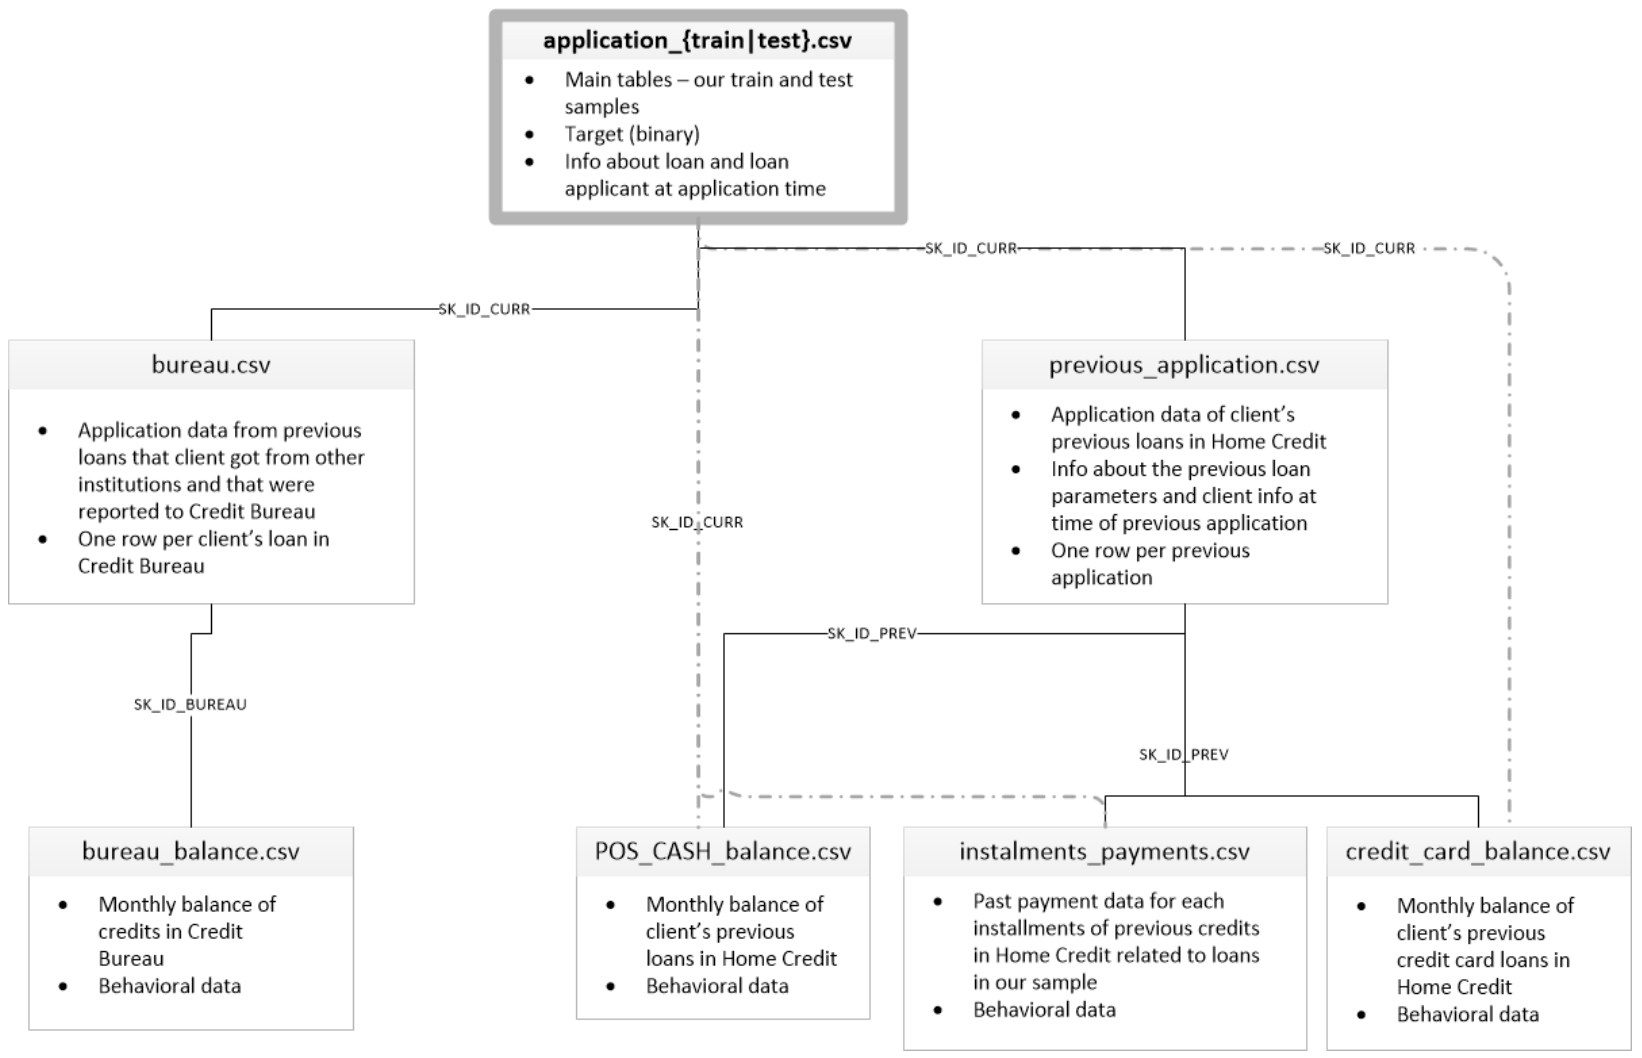

In [7]:
for key, val in Datas.items():
    print(f"{key} : Dimension : {val.shape}")
    display_html(Datas[key].head(3))
    

    print("\n")

application_test_df : Dimension : (48744, 121)


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0




HomeCredit_columns_description_df : Dimension : (219, 4)


,Table,Row,Description,Special
1,application_{train|test}.csv,SK_ID_CURR,ID of loan in our sample,NaN
2,application_{train|test}.csv,TARGET,Target variable (1 - client with payment diffi...,NaN
5,application_{train|test}.csv,NAME_CONTRACT_TYPE,Identification if loan is cash or revolving,NaN




POS_CASH_balance_df : Dimension : (10001358, 8)


,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0




credit_card_balance_df : Dimension : (3840312, 23)


,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,...,0.000,0.000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.000,...,64875.555,64875.555,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.225,450000,0.0,0.0,0.0,0.0,2250.000,...,31460.085,31460.085,0.0,0,0.0,0.0,30.0,Active,0,0




installments_payments_df : Dimension : (13605401, 8)


,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000,25425.000




application_train_df : Dimension : (307511, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0




bureau_df : Dimension : (1716428, 17)


,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN




previous_application_df : Dimension : (1670214, 37)


,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,...,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,...,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,...,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0




bureau_balance_df : Dimension : (27299925, 3)


,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C




sample_submission_df : Dimension : (48744, 2)


,SK_ID_CURR,TARGET
0,100001,0.5
1,100005,0.5
2,100013,0.5


### Valeurs manquantes

In [8]:
for key, val in Datas.items():
    #print(key, ": % de NaN\n")
    print(key, ":", round((val.isna().sum()/len(val)*100).sum()/val.shape[1], 2), " % of NaN\n")

application_test_df : 23.81  % of NaN

HomeCredit_columns_description_df : 15.18  % of NaN

POS_CASH_balance_df : 0.07  % of NaN

credit_card_balance_df : 6.65  % of NaN

installments_payments_df : 0.01  % of NaN

application_train_df : 24.4  % of NaN

bureau_df : 13.5  % of NaN

previous_application_df : 17.98  % of NaN

bureau_balance_df : 0.0  % of NaN

sample_submission_df : 0.0  % of NaN



In [9]:
for key, val in Datas.items():
    print(key, f" : Nombre de variables totales : {len(val.columns)}")
    df = pd.DataFrame(val.isna().sum(), columns=['nb_Nan'])
    df = df[df['nb_Nan'] > 0]
    if len(df) == 0:
        print(key, "Pas de valeurs manquantes")
    
    else:
        display_html(df)
    
    print("\n")

application_test_df  : Nombre de variables totales : 121


,nb_Nan
AMT_ANNUITY,24
NAME_TYPE_SUITE,911
OWN_CAR_AGE,32312
OCCUPATION_TYPE,15605
EXT_SOURCE_1,20532
...,...
AMT_REQ_CREDIT_BUREAU_DAY,6049
AMT_REQ_CREDIT_BUREAU_WEEK,6049
AMT_REQ_CREDIT_BUREAU_MON,6049
AMT_REQ_CREDIT_BUREAU_QRT,6049




HomeCredit_columns_description_df  : Nombre de variables totales : 4


,nb_Nan
Special,133




POS_CASH_balance_df  : Nombre de variables totales : 8


,nb_Nan
CNT_INSTALMENT,26071
CNT_INSTALMENT_FUTURE,26087




credit_card_balance_df  : Nombre de variables totales : 23


,nb_Nan
AMT_DRAWINGS_ATM_CURRENT,749816
AMT_DRAWINGS_OTHER_CURRENT,749816
AMT_DRAWINGS_POS_CURRENT,749816
AMT_INST_MIN_REGULARITY,305236
AMT_PAYMENT_CURRENT,767988
CNT_DRAWINGS_ATM_CURRENT,749816
CNT_DRAWINGS_OTHER_CURRENT,749816
CNT_DRAWINGS_POS_CURRENT,749816
CNT_INSTALMENT_MATURE_CUM,305236




installments_payments_df  : Nombre de variables totales : 8


,nb_Nan
DAYS_ENTRY_PAYMENT,2905
AMT_PAYMENT,2905




application_train_df  : Nombre de variables totales : 122


,nb_Nan
AMT_ANNUITY,12
AMT_GOODS_PRICE,278
NAME_TYPE_SUITE,1292
OWN_CAR_AGE,202929
OCCUPATION_TYPE,96391
...,...
AMT_REQ_CREDIT_BUREAU_DAY,41519
AMT_REQ_CREDIT_BUREAU_WEEK,41519
AMT_REQ_CREDIT_BUREAU_MON,41519
AMT_REQ_CREDIT_BUREAU_QRT,41519




bureau_df  : Nombre de variables totales : 17


,nb_Nan
DAYS_CREDIT_ENDDATE,105553
DAYS_ENDDATE_FACT,633653
AMT_CREDIT_MAX_OVERDUE,1124488
AMT_CREDIT_SUM,13
AMT_CREDIT_SUM_DEBT,257669
AMT_CREDIT_SUM_LIMIT,591780
AMT_ANNUITY,1226791




previous_application_df  : Nombre de variables totales : 37


,nb_Nan
AMT_ANNUITY,372235
AMT_CREDIT,1
AMT_DOWN_PAYMENT,895844
AMT_GOODS_PRICE,385515
RATE_DOWN_PAYMENT,895844
RATE_INTEREST_PRIMARY,1664263
RATE_INTEREST_PRIVILEGED,1664263
NAME_TYPE_SUITE,820405
CNT_PAYMENT,372230
PRODUCT_COMBINATION,346




bureau_balance_df  : Nombre de variables totales : 3
bureau_balance_df Pas de valeurs manquantes


sample_submission_df  : Nombre de variables totales : 2
sample_submission_df Pas de valeurs manquantes




### Doublons

In [10]:
#Doublons
for key, val in Datas.items():
   
    print(key, ":", val.duplicated().sum(), " doublons\n")

application_test_df : 0  doublons

HomeCredit_columns_description_df : 0  doublons

POS_CASH_balance_df : 0  doublons

credit_card_balance_df : 0  doublons

installments_payments_df : 0  doublons

application_train_df : 0  doublons

bureau_df : 0  doublons

previous_application_df : 0  doublons

bureau_balance_df : 0  doublons

sample_submission_df : 0  doublons



### Describes

In [11]:
#Variables numériques
for key, val in Datas.items():
    
    print(key)
    try:
        display_html(val.describe(include=np.number))
        print("\n")
    except ValueError:
        print("Pas de variable numérique !\n")

application_test_df


,SK_ID_CURR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,48744.000000,48744.000000,4.874400e+04,4.874400e+04,48720.000000,4.874400e+04,48744.000000,48744.000000,48744.000000,48744.000000,...,48744.000000,48744.0,48744.0,48744.0,42695.000000,42695.000000,42695.000000,42695.000000,42695.000000,42695.000000
mean,277796.676350,0.397054,1.784318e+05,5.167404e+05,29426.240209,4.626188e+05,0.021226,-16068.084605,67485.366322,-4967.652716,...,0.001559,0.0,0.0,0.0,0.002108,0.001803,0.002787,0.009299,0.546902,1.983769
std,103169.547296,0.709047,1.015226e+05,3.653970e+05,16016.368315,3.367102e+05,0.014428,4325.900393,144348.507136,3552.612035,...,0.039456,0.0,0.0,0.0,0.046373,0.046132,0.054037,0.110924,0.693305,1.838873
min,100001.000000,0.000000,2.694150e+04,4.500000e+04,2295.000000,4.500000e+04,0.000253,-25195.000000,-17463.000000,-23722.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,188557.750000,0.000000,1.125000e+05,2.606400e+05,17973.000000,2.250000e+05,0.010006,-19637.000000,-2910.000000,-7459.250000,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,277549.000000,0.000000,1.575000e+05,4.500000e+05,26199.000000,3.960000e+05,0.018850,-15785.000000,-1293.000000,-4490.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
75%,367555.500000,1.000000,2.250000e+05,6.750000e+05,37390.500000,6.300000e+05,0.028663,-12496.000000,-296.000000,-1901.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,1.000000,3.000000
max,456250.000000,20.000000,4.410000e+06,2.245500e+06,180576.000000,2.245500e+06,0.072508,-7338.000000,365243.000000,0.000000,...,1.000000,0.0,0.0,0.0,2.000000,2.000000,2.000000,6.000000,7.000000,17.000000




HomeCredit_columns_description_df
Pas de variable numérique !

POS_CASH_balance_df


,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,SK_DPD,SK_DPD_DEF
count,1.000136e+07,1.000136e+07,1.000136e+07,9.975287e+06,9.975271e+06,1.000136e+07,1.000136e+07
mean,1.903217e+06,2.784039e+05,-3.501259e+01,1.708965e+01,1.048384e+01,1.160693e+01,6.544684e-01
std,5.358465e+05,1.027637e+05,2.606657e+01,1.199506e+01,1.110906e+01,1.327140e+02,3.276249e+01
min,1.000001e+06,1.000010e+05,-9.600000e+01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.434405e+06,1.895500e+05,-5.400000e+01,1.000000e+01,3.000000e+00,0.000000e+00,0.000000e+00
50%,1.896565e+06,2.786540e+05,-2.800000e+01,1.200000e+01,7.000000e+00,0.000000e+00,0.000000e+00
75%,2.368963e+06,3.674290e+05,-1.300000e+01,2.400000e+01,1.400000e+01,0.000000e+00,0.000000e+00
max,2.843499e+06,4.562550e+05,-1.000000e+00,9.200000e+01,8.500000e+01,4.231000e+03,3.595000e+03




credit_card_balance_df


,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,SK_DPD,SK_DPD_DEF
count,3.840312e+06,3.840312e+06,3.840312e+06,3.840312e+06,3.840312e+06,3.090496e+06,3.840312e+06,3.090496e+06,3.090496e+06,3.535076e+06,...,3.840312e+06,3.840312e+06,3.840312e+06,3.090496e+06,3.840312e+06,3.090496e+06,3.090496e+06,3.535076e+06,3.840312e+06,3.840312e+06
mean,1.904504e+06,2.783242e+05,-3.452192e+01,5.830016e+04,1.538080e+05,5.961325e+03,7.433388e+03,2.881696e+02,2.968805e+03,3.540204e+03,...,5.596588e+04,5.808881e+04,5.809829e+04,3.094490e-01,7.031439e-01,4.812496e-03,5.594791e-01,2.082508e+01,9.283667e+00,3.316220e-01
std,5.364695e+05,1.027045e+05,2.666775e+01,1.063070e+05,1.651457e+05,2.822569e+04,3.384608e+04,8.201989e+03,2.079689e+04,5.600154e+03,...,1.025336e+05,1.059654e+05,1.059718e+05,1.100401e+00,3.190347e+00,8.263861e-02,3.240649e+00,2.005149e+01,9.751570e+01,2.147923e+01
min,1.000018e+06,1.000060e+05,-9.600000e+01,-4.202502e+05,0.000000e+00,-6.827310e+03,-6.211620e+03,0.000000e+00,0.000000e+00,0.000000e+00,...,-4.233058e+05,-4.202502e+05,-4.202502e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.434385e+06,1.895170e+05,-5.500000e+01,0.000000e+00,4.500000e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.000000e+00,0.000000e+00,0.000000e+00
50%,1.897122e+06,2.783960e+05,-2.800000e+01,0.000000e+00,1.125000e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.500000e+01,0.000000e+00,0.000000e+00
75%,2.369328e+06,3.675800e+05,-1.100000e+01,8.904669e+04,1.800000e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.633911e+03,...,8.535924e+04,8.889949e+04,8.891451e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.200000e+01,0.000000e+00,0.000000e+00
max,2.843496e+06,4.562500e+05,-1.000000e+00,1.505902e+06,1.350000e+06,2.115000e+06,2.287098e+06,1.529847e+06,2.239274e+06,2.028820e+05,...,1.472317e+06,1.493338e+06,1.493338e+06,5.100000e+01,1.650000e+02,1.200000e+01,1.650000e+02,1.200000e+02,3.260000e+03,3.260000e+03




installments_payments_df


,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
count,1.360540e+07,1.360540e+07,1.360540e+07,1.360540e+07,1.360540e+07,1.360250e+07,1.360540e+07,1.360250e+07
mean,1.903365e+06,2.784449e+05,8.566373e-01,1.887090e+01,-1.042270e+03,-1.051114e+03,1.705091e+04,1.723822e+04
std,5.362029e+05,1.027183e+05,1.035216e+00,2.666407e+01,8.009463e+02,8.005859e+02,5.057025e+04,5.473578e+04
min,1.000001e+06,1.000010e+05,0.000000e+00,1.000000e+00,-2.922000e+03,-4.921000e+03,0.000000e+00,0.000000e+00
25%,1.434191e+06,1.896390e+05,0.000000e+00,4.000000e+00,-1.654000e+03,-1.662000e+03,4.226085e+03,3.398265e+03
50%,1.896520e+06,2.786850e+05,1.000000e+00,8.000000e+00,-8.180000e+02,-8.270000e+02,8.884080e+03,8.125515e+03
75%,2.369094e+06,3.675300e+05,1.000000e+00,1.900000e+01,-3.610000e+02,-3.700000e+02,1.671021e+04,1.610842e+04
max,2.843499e+06,4.562550e+05,1.780000e+02,2.770000e+02,-1.000000e+00,-1.000000e+00,3.771488e+06,3.771488e+06




application_train_df


,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,307511.000000,307511.000000,307511.000000,3.075110e+05,3.075110e+05,307499.000000,3.072330e+05,307511.000000,307511.000000,307511.000000,...,307511.000000,307511.000000,307511.000000,307511.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000
mean,278180.518577,0.080729,0.417052,1.687979e+05,5.990260e+05,27108.573909,5.383962e+05,0.020868,-16036.995067,63815.045904,...,0.008130,0.000595,0.000507,0.000335,0.006402,0.007000,0.034362,0.267395,0.265474,1.899974
std,102790.175348,0.272419,0.722121,2.371231e+05,4.024908e+05,14493.737315,3.694465e+05,0.013831,4363.988632,141275.766519,...,0.089798,0.024387,0.022518,0.018299,0.083849,0.110757,0.204685,0.916002,0.794056,1.869295
min,100002.000000,0.000000,0.000000,2.565000e+04,4.500000e+04,1615.500000,4.050000e+04,0.000290,-25229.000000,-17912.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,189145.500000,0.000000,0.000000,1.125000e+05,2.700000e+05,16524.000000,2.385000e+05,0.010006,-19682.000000,-2760.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,278202.000000,0.000000,0.000000,1.471500e+05,5.135310e+05,24903.000000,4.500000e+05,0.018850,-15750.000000,-1213.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,367142.500000,0.000000,1.000000,2.025000e+05,8.086500e+05,34596.000000,6.795000e+05,0.028663,-12413.000000,-289.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
max,456255.000000,1.000000,19.000000,1.170000e+08,4.050000e+06,258025.500000,4.050000e+06,0.072508,-7489.000000,365243.000000,...,1.000000,1.000000,1.000000,1.000000,4.000000,9.000000,8.000000,27.000000,261.000000,25.000000




bureau_df


,SK_ID_CURR,SK_ID_BUREAU,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
count,1.716428e+06,1.716428e+06,1.716428e+06,1.716428e+06,1.610875e+06,1.082775e+06,5.919400e+05,1.716428e+06,1.716415e+06,1.458759e+06,1.124648e+06,1.716428e+06,1.716428e+06,4.896370e+05
mean,2.782149e+05,5.924434e+06,-1.142108e+03,8.181666e-01,5.105174e+02,-1.017437e+03,3.825418e+03,6.410406e-03,3.549946e+05,1.370851e+05,6.229515e+03,3.791276e+01,-5.937483e+02,1.571276e+04
std,1.029386e+05,5.322657e+05,7.951649e+02,3.654443e+01,4.994220e+03,7.140106e+02,2.060316e+05,9.622391e-02,1.149811e+06,6.774011e+05,4.503203e+04,5.937650e+03,7.207473e+02,3.258269e+05
min,1.000010e+05,5.000000e+06,-2.922000e+03,0.000000e+00,-4.206000e+04,-4.202300e+04,0.000000e+00,0.000000e+00,0.000000e+00,-4.705600e+06,-5.864061e+05,0.000000e+00,-4.194700e+04,0.000000e+00
25%,1.888668e+05,5.463954e+06,-1.666000e+03,0.000000e+00,-1.138000e+03,-1.489000e+03,0.000000e+00,0.000000e+00,5.130000e+04,0.000000e+00,0.000000e+00,0.000000e+00,-9.080000e+02,0.000000e+00
50%,2.780550e+05,5.926304e+06,-9.870000e+02,0.000000e+00,-3.300000e+02,-8.970000e+02,0.000000e+00,0.000000e+00,1.255185e+05,0.000000e+00,0.000000e+00,0.000000e+00,-3.950000e+02,0.000000e+00
75%,3.674260e+05,6.385681e+06,-4.740000e+02,0.000000e+00,4.740000e+02,-4.250000e+02,0.000000e+00,0.000000e+00,3.150000e+05,4.015350e+04,0.000000e+00,0.000000e+00,-3.300000e+01,1.350000e+04
max,4.562550e+05,6.843457e+06,0.000000e+00,2.792000e+03,3.119900e+04,0.000000e+00,1.159872e+08,9.000000e+00,5.850000e+08,1.701000e+08,4.705600e+06,3.756681e+06,3.720000e+02,1.184534e+08




previous_application_df


,SK_ID_PREV,SK_ID_CURR,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,HOUR_APPR_PROCESS_START,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,...,RATE_INTEREST_PRIVILEGED,DAYS_DECISION,SELLERPLACE_AREA,CNT_PAYMENT,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
count,1.670214e+06,1.670214e+06,1.297979e+06,1.670214e+06,1.670213e+06,7.743700e+05,1.284699e+06,1.670214e+06,1.670214e+06,774370.000000,...,5951.000000,1.670214e+06,1.670214e+06,1.297984e+06,997149.000000,997149.000000,997149.000000,997149.000000,997149.000000,997149.000000
mean,1.923089e+06,2.783572e+05,1.595512e+04,1.752339e+05,1.961140e+05,6.697402e+03,2.278473e+05,1.248418e+01,9.964675e-01,0.079637,...,0.773503,-8.806797e+02,3.139511e+02,1.605408e+01,342209.855039,13826.269337,33767.774054,76582.403064,81992.343838,0.332570
std,5.325980e+05,1.028148e+05,1.478214e+04,2.927798e+05,3.185746e+05,2.092150e+04,3.153966e+05,3.334028e+00,5.932963e-02,0.107823,...,0.100879,7.790997e+02,7.127443e+03,1.456729e+01,88916.115834,72444.869708,106857.034789,149647.415123,153303.516729,0.471134
min,1.000001e+06,1.000010e+05,0.000000e+00,0.000000e+00,0.000000e+00,-9.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00,-0.000015,...,0.373150,-2.922000e+03,-1.000000e+00,0.000000e+00,-2922.000000,-2892.000000,-2801.000000,-2889.000000,-2874.000000,0.000000
25%,1.461857e+06,1.893290e+05,6.321780e+03,1.872000e+04,2.416050e+04,0.000000e+00,5.084100e+04,1.000000e+01,1.000000e+00,0.000000,...,0.715645,-1.300000e+03,-1.000000e+00,6.000000e+00,365243.000000,-1628.000000,-1242.000000,-1314.000000,-1270.000000,0.000000
50%,1.923110e+06,2.787145e+05,1.125000e+04,7.104600e+04,8.054100e+04,1.638000e+03,1.123200e+05,1.200000e+01,1.000000e+00,0.051605,...,0.835095,-5.810000e+02,3.000000e+00,1.200000e+01,365243.000000,-831.000000,-361.000000,-537.000000,-499.000000,0.000000
75%,2.384280e+06,3.675140e+05,2.065842e+04,1.803600e+05,2.164185e+05,7.740000e+03,2.340000e+05,1.500000e+01,1.000000e+00,0.108909,...,0.852537,-2.800000e+02,8.200000e+01,2.400000e+01,365243.000000,-411.000000,129.000000,-74.000000,-44.000000,1.000000
max,2.845382e+06,4.562550e+05,4.180581e+05,6.905160e+06,6.905160e+06,3.060045e+06,6.905160e+06,2.300000e+01,1.000000e+00,1.000000,...,1.000000,-1.000000e+00,4.000000e+06,8.400000e+01,365243.000000,365243.000000,365243.000000,365243.000000,365243.000000,1.000000




bureau_balance_df


,SK_ID_BUREAU,MONTHS_BALANCE
count,2.729992e+07,2.729992e+07
mean,6.036297e+06,-3.074169e+01
std,4.923489e+05,2.386451e+01
min,5.001709e+06,-9.600000e+01
25%,5.730933e+06,-4.600000e+01
50%,6.070821e+06,-2.500000e+01
75%,6.431951e+06,-1.100000e+01
max,6.842888e+06,0.000000e+00




sample_submission_df


,SK_ID_CURR,TARGET
count,48744.000000,48744.0
mean,277796.676350,0.5
std,103169.547296,0.0
min,100001.000000,0.5
25%,188557.750000,0.5
50%,277549.000000,0.5
75%,367555.500000,0.5
max,456250.000000,0.5


In [12]:
#Variable catégorielles
for key, val in Datas.items():
    
    print(key)
    try:
        display_html(val.describe(exclude=np.number))
        print("\n")
    except ValueError:
        print("Pas de variable objet !\n")

application_test_df


,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,WEEKDAY_APPR_PROCESS_START,ORGANIZATION_TYPE,FONDKAPREMONT_MODE,HOUSETYPE_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE
count,48744,48744,48744,48744,47833,48744,48744,48744,48744,33139,48744,48744,15947,25125,24851,26535
unique,2,2,2,2,7,7,5,5,6,18,7,58,4,3,7,2
top,Cash loans,F,N,Y,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,Laborers,TUESDAY,Business Entity Type 3,reg oper account,block of flats,Panel,No
freq,48305,32678,32311,33658,39727,24533,33988,32283,43645,8655,9751,10840,12124,24659,11269,26179




HomeCredit_columns_description_df


,Table,Row,Description,Special
count,219,219,219,86
unique,7,196,163,7
top,application_{train|test}.csv,SK_ID_CURR,Normalized information about building where th...,normalized
freq,122,6,47,53




POS_CASH_balance_df


,NAME_CONTRACT_STATUS
count,10001358
unique,9
top,Active
freq,9151119




credit_card_balance_df


,NAME_CONTRACT_STATUS
count,3840312
unique,7
top,Active
freq,3698436




installments_payments_df
Pas de variable objet !

application_train_df


,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,WEEKDAY_APPR_PROCESS_START,ORGANIZATION_TYPE,FONDKAPREMONT_MODE,HOUSETYPE_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE
count,307511,307511,307511,307511,306219,307511,307511,307511,307511,211120,307511,307511,97216,153214,151170,161756
unique,2,3,2,2,7,8,5,6,6,18,7,58,4,3,7,2
top,Cash loans,F,N,Y,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,Laborers,TUESDAY,Business Entity Type 3,reg oper account,block of flats,Panel,No
freq,278232,202448,202924,213312,248526,158774,218391,196432,272868,55186,53901,67992,73830,150503,66040,159428




bureau_df


,CREDIT_ACTIVE,CREDIT_CURRENCY,CREDIT_TYPE
count,1716428,1716428,1716428
unique,4,4,15
top,Closed,currency 1,Consumer credit
freq,1079273,1715020,1251615




previous_application_df


,NAME_CONTRACT_TYPE,WEEKDAY_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,NAME_SELLER_INDUSTRY,NAME_YIELD_GROUP,PRODUCT_COMBINATION
count,1670214,1670214,1670214,1670214,1670214,1670214,1670214,849809,1670214,1670214,1670214,1670214,1670214,1670214,1670214,1669868
unique,4,7,2,25,4,4,9,7,4,28,5,3,8,11,5,17
top,Cash loans,TUESDAY,Y,XAP,Approved,Cash through the bank,XAP,Unaccompanied,Repeater,XNA,POS,XNA,Credit and cash offices,XNA,XNA,Cash
freq,747553,255118,1661739,922661,1036781,1033552,1353093,508970,1231261,950809,691011,1063666,719968,855720,517215,285990




bureau_balance_df


,STATUS
count,27299925
unique,8
top,C
freq,13646993




sample_submission_df
Pas de variable objet !



In [13]:
#Confirmation qu'il n'y a qu'une seule colonne de différence entre le train et test
set(Datas['application_train_df'].columns).difference(set(Datas['application_test_df']))

{'TARGET'}

In [14]:
#Nombre de clients
nb_clients = Datas['application_train_df']['SK_ID_CURR'].nunique()
nb_clients

307511

Ce nombre correspond bien à la dimension de la table des cliens 
    
  - (307511, 122) 307511 Clients décrit avec 122 variables

In [15]:
#Repartition des targets
Datas['application_train_df']['TARGET'].value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

In [16]:
#Repartition des targets (%)
np.round(Datas['application_train_df']['TARGET'].value_counts()/nb_clients*100, 1)

0    91.9
1     8.1
Name: TARGET, dtype: float64

- Nous pouvons constater un déséquilibre entre ces deux classes

- Que signifie ces classes ?

In [17]:
#description de la variable target dans la table description
row = Datas['HomeCredit_columns_description_df'][
    (Datas['HomeCredit_columns_description_df']['Table'] == 'application_{train|test}.csv') &
    (Datas['HomeCredit_columns_description_df']['Row'] == 'TARGET')
].iloc[0]
row

Table                               application_{train|test}.csv
Row                                                       TARGET
Description    Target variable (1 - client with payment diffi...
Special                                                      NaN
Name: 2, dtype: object

In [18]:
row.Description

'Target variable (1 - client with payment difficulties: he/she had late payment more than X days on at least one of the first Y installments of the loan in our sample, 0 - all other cases)'

- 1 : Difficulté de paiement au moins une mensualité de retard d'un certain nombres de jours **(Défaut de crédit)**
- 0 : Tous les cas, remboursement encore en cours ou finalisé etc.**(Pas Défaut de crédit)**

In [19]:
#Repartition des genres
Datas['application_train_df']['CODE_GENDER'].value_counts()

F      202448
M      105059
XNA         4
Name: CODE_GENDER, dtype: int64

In [20]:
#Repartition des genres (%)
np.round(Datas['application_train_df']['CODE_GENDER'].value_counts()/nb_clients*100, 3)

F      65.834
M      34.164
XNA     0.001
Name: CODE_GENDER, dtype: float64

- Nous avons un déséquilibre entre le nombre d’Hommes et Femmes.
- En effet les Femmes sont deux fois plus nombreuses que les hommes parmi les clients de l’entreprise.

# Feature ingineering

- Application d’un kernel Kaggle.

## Application de Kernel Kaggle

### application_train_test preprocessing

Ajout de 5 nouvelles features : 


- **DAYS_EMPLOYED_PERC** : le pourcentage de jours employés par rapport à l'âge du client
- **INCOME_CREDIT_PERC** : le pourcentage du revenu total du client par rapport au montant total du crédit
- **INCOME_PER_PERSON** : le pourcentage du revenu total du client par rapport au nombre de mebre de son foyer
- **ANNUITY_INCOME_PERC** : le pourcentage du montant mensuel du crédit par rapport au revenu total
- **PAYMENT_RATE** : le taux de remboursement du crédit

In [21]:
#Regroupement de train et test table et calcul des nouvelles variables
app_train_test_df = ksf.application_train_test()
app_train_test_df = udf.reduce_mem_usage(app_train_test_df)
app_train_test_df.head()

Train samples: 307511, test samples: 48744
Memory usage of dataframe is 360.47 MB
Memory usage after optimization is: 162.74 MB
Decreased by 54.9%


,index,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,DAYS_EMPLOYED_PERC,INCOME_CREDIT_PERC,INCOME_PER_PERSON,ANNUITY_INCOME_PERC,PAYMENT_RATE
0,0,100002,1.0,0,0,0,0,202500.0,406597.5,24700.5,...,0.0,1.0,0.0,1.0,0.0,0.067322,0.498047,202500.0,0.121948,0.060760
1,1,100003,0.0,1,0,1,0,270000.0,1293502.5,35698.5,...,0.0,0.0,0.0,1.0,0.0,0.070862,0.208740,135000.0,0.132202,0.027603
2,2,100004,0.0,0,1,0,0,67500.0,135000.0,6750.0,...,0.0,0.0,0.0,0.0,0.0,0.011810,0.500000,67500.0,0.099976,0.049988
3,3,100006,0.0,1,0,0,0,135000.0,312682.5,29686.5,...,0.0,0.0,0.0,0.0,0.0,0.159912,0.431641,67500.0,0.219849,0.094971
4,4,100007,0.0,0,0,0,0,121500.0,513000.0,21865.5,...,0.0,0.0,0.0,0.0,0.0,0.152466,0.236816,121500.0,0.179932,0.042633


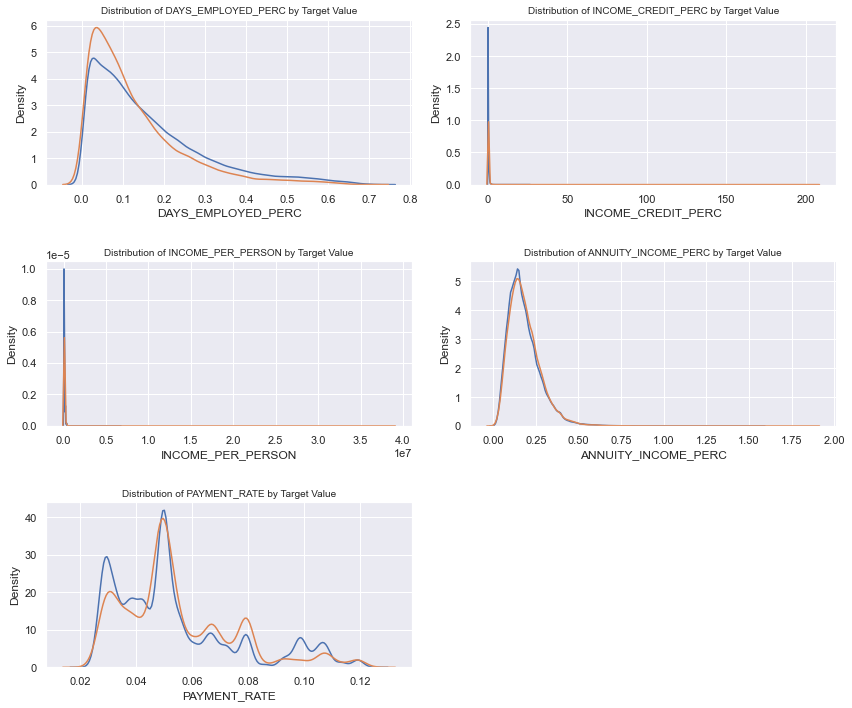

In [22]:
#Distribution des nouvelles variables
plt.figure(figsize = (12, 10))
# iterate through the new features
for i, feature in enumerate([
    'DAYS_EMPLOYED_PERC', 'INCOME_CREDIT_PERC', 'INCOME_PER_PERSON', 'ANNUITY_INCOME_PERC', 'PAYMENT_RATE'
]):
    
    # create a new subplot for each source
    plt.subplot(3, 2, i + 1)
    # plot repaid loans
    sns.kdeplot(app_train_test_df.loc[app_train_test_df['TARGET'] == 0, feature], label = 'target == 0')
    # plot loans that were not repaid
    sns.kdeplot(app_train_test_df.loc[app_train_test_df['TARGET'] == 1, feature], label = 'target == 1')
    
    # Label the plots
    plt.title('Distribution of %s by Target Value' % feature, size=10)
    plt.xlabel('%s' % feature); plt.ylabel('Density');
    
plt.tight_layout(h_pad = 2.5)

## Data preprocessing

### Sélection de features

- Regardons le pourcentage de valeurs manquantes, les corrélations des variables avec la cible, et aussi la corrélation des variables avec les autres variables. Les corrélations entre les variables peuvent montrer présence des variables colinéaires, c'est-à-dire des variables fortement corrélées entre elles. Souvent, nous voulons en supprimer une pour une paire de variables colinéaires car avoir les deux variables serait redondant. Nous pouvons également utiliser le pourcentage de valeurs manquantes pour supprimer les fonctionnalités avec une majorité substantielle de valeurs qui ne sont pas présentes. La sélection de variables sera un objectif important pour la suite, car la réduction du nombre de variable peut aider le modèle à apprendre pendant l’entrainement et également à mieux généraliser les données d’entrainement. La « malédiction de la dimensionnalité » est le nom donné aux problèmes causés par le fait d'avoir trop de variable/features (une dimension trop élevée). À mesure que le nombre de variables augmente, le nombre de points de données nécessaires pour apprendre la relation entre ces variables et la valeur cible augmente de façon exponentielle.


- La sélection des variables est le processus de suppression des variables pour aider notre modèle à apprendre et à mieux généraliser à l'ensemble de test. L'objectif est de supprimer les variables inutiles/redondantes tout en préservant celles qui sont utiles. Il existe un certain nombre d'outils que nous pouvons utiliser pour ce processus. Ici, nous nous en tiendrons à supprimer les colonnes avec un pourcentage élevé de valeurs manquantes et de variables qui ont une forte corrélation les unes avec les autres. Plus tard, nous pourrons envisager d'utiliser les importances des variable/feature renvoyées par des modèles tels que Gradient Boosting Machine ou Random Forest pour effectuer la sélection des features.


In [23]:
#Chargement des données prétraitées
data_preproced = ksf.main()
del data_preproced['index']
data_preproced = udf.reduce_mem_usage(data_preproced)
data_preproced.head()

Train samples: 307511, test samples: 48744
Bureau df shape: (305811, 116)
Process bureau and bureau_balance - done in 31s
Previous applications df shape: (338857, 249)
Process previous_applications - done in 35s
Pos-cash balance df shape: (337252, 18)
Process POS-CASH balance - done in 22s
Installments payments df shape: (339587, 26)
Process installments payments - done in 53s
Credit card balance df shape: (103558, 141)
Process credit card balance - done in 39s
Memory usage of dataframe is 1852.64 MB
Memory usage after optimization is: 650.62 MB
Decreased by 64.9%


,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,CC_NAME_CONTRACT_STATUS_Signed_MAX,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_NAME_CONTRACT_STATUS_nan_MIN,CC_NAME_CONTRACT_STATUS_nan_MAX,CC_NAME_CONTRACT_STATUS_nan_MEAN,CC_NAME_CONTRACT_STATUS_nan_SUM,CC_NAME_CONTRACT_STATUS_nan_VAR,CC_COUNT
0,100002,1.0,0,0,0,0,202500.0,406597.5,24700.5,351000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,100003,0.0,1,0,1,0,270000.0,1293502.5,35698.5,1129500.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,100004,0.0,0,1,0,0,67500.0,135000.0,6750.0,135000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,100006,0.0,1,0,0,0,135000.0,312682.5,29686.5,297000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0
4,100007,0.0,0,0,0,0,121500.0,513000.0,21865.5,513000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
data_preproced.shape

(356251, 797)

In [25]:
#Sauvegarde des données
#data_preproced.to_csv(Path(PROJECT_ROOT + '/data/data_preprocessed.csv'), index=False)

In [26]:
data_preproced = pd.read_csv(Path(PROJECT_ROOT + '/data/data_preprocessed.csv'))
del data_preproced['index']
data_preproced.head()

,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,CC_NAME_CONTRACT_STATUS_Signed_MAX,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_NAME_CONTRACT_STATUS_nan_MIN,CC_NAME_CONTRACT_STATUS_nan_MAX,CC_NAME_CONTRACT_STATUS_nan_MEAN,CC_NAME_CONTRACT_STATUS_nan_SUM,CC_NAME_CONTRACT_STATUS_nan_VAR,CC_COUNT
0,100002,1.0,0,0,0,0,202500.0,406597.5,24700.5,351000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,100003,0.0,1,0,1,0,270000.0,1293502.5,35698.5,1129500.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,100004,0.0,0,1,0,0,67500.0,135000.0,6750.0,135000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,100006,0.0,1,0,0,0,135000.0,312682.5,29686.5,297000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0
4,100007,0.0,0,0,0,0,121500.0,513000.0,21865.5,513000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Valeurs manquantes

- Partant de l’hypothèse que les valeurs manquantes proviennent du fait que le client n’ait pas de valeur pour la variable concernée.

In [27]:
colums_with_target = data_preproced.columns.to_list()
colums_without_target = colums_with_target.copy()
colums_without_target.remove('TARGET')
colums_without_target.remove('SK_ID_CURR')
colums_without_target

['CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'REGION_POPULATION_RELATIVE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'OWN_CAR_AGE',
 'FLAG_MOBIL',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_CONT_MOBILE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'CNT_FAM_MEMBERS',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'HOUR_APPR_PROCESS_START',
 'REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'LIVE_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'LIVE_CITY_NOT_WORK_CITY',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'APARTMENTS_AVG',
 'BASEMENTAREA_AVG',
 'YEARS_BEGINEXPLUATATION_AVG',
 'YEARS_BUILD_AVG',
 'COMMONAREA_AVG',
 'ELEVATORS_AVG',
 'ENTRANCES_AVG',
 'FLOORSMAX_AVG',
 'FLOORSMIN_AVG',
 'LANDAREA_AVG',
 'LIVINGAPARTMENTS_AVG',
 'LIVINGAREA_AVG',
 'NONLIVINGAPARTMENTS_AVG',
 'NONLIVINGAREA_AVG',
 'APA

In [28]:
missing_data = udf.missing_values_table(data_preproced[colums_without_target])
missing_data.head(10)

Your selected dataframe has 795 columns.
There are 616 columns that have missing values.


,Missing Values,% of Total Values
REFUSED_RATE_DOWN_PAYMENT_MAX,303648,85.2
REFUSED_RATE_DOWN_PAYMENT_MEAN,303648,85.2
REFUSED_AMT_DOWN_PAYMENT_MEAN,303648,85.2
REFUSED_AMT_DOWN_PAYMENT_MAX,303648,85.2
REFUSED_AMT_DOWN_PAYMENT_MIN,303648,85.2
REFUSED_RATE_DOWN_PAYMENT_MIN,303648,85.2
REFUSED_APP_CREDIT_PERC_VAR,298034,83.7
CC_AMT_PAYMENT_CURRENT_VAR,284649,79.9
CC_CNT_DRAWINGS_POS_CURRENT_VAR,284559,79.9
CC_AMT_DRAWINGS_POS_CURRENT_VAR,284559,79.9


In [29]:
#Suppression de variable présentant plus de de 80% de valeurs manquantes
missing_vars_to_remove = list(missing_data.index[missing_data['% of Total Values'] > 80])
len(missing_vars_to_remove)

7

In [30]:
missing_vars_to_remove

['REFUSED_RATE_DOWN_PAYMENT_MAX',
 'REFUSED_RATE_DOWN_PAYMENT_MEAN',
 'REFUSED_AMT_DOWN_PAYMENT_MEAN',
 'REFUSED_AMT_DOWN_PAYMENT_MAX',
 'REFUSED_AMT_DOWN_PAYMENT_MIN',
 'REFUSED_RATE_DOWN_PAYMENT_MIN',
 'REFUSED_APP_CREDIT_PERC_VAR']

In [31]:
#imputation par 0.
data_preproced.fillna(0, inplace=True)

#### Corrélations

- Regardons les corrélations avec target

In [32]:
# All
corrs = data_preproced.corr()

In [33]:
#Corrélation avec la variable cible target
corr_with_target = pd.DataFrame(corrs['TARGET']).reset_index().round(2)
corr_with_target.rename(columns={'index':'Variable', 'TARGET': 'corr'}, inplace=True)

In [34]:
corr_with_target

,Variable,corr
0,SK_ID_CURR,-0.00
1,TARGET,1.00
2,CODE_GENDER,-0.05
3,FLAG_OWN_CAR,-0.02
4,FLAG_OWN_REALTY,0.01
...,...,...
792,CC_NAME_CONTRACT_STATUS_nan_MAX,NaN
793,CC_NAME_CONTRACT_STATUS_nan_MEAN,NaN
794,CC_NAME_CONTRACT_STATUS_nan_SUM,NaN
795,CC_NAME_CONTRACT_STATUS_nan_VAR,NaN


In [35]:
corr_with_target.sort_values('corr', ascending=False)

,Variable,corr
1,TARGET,1.00
249,BURO_DAYS_CREDIT_MEAN,0.08
247,BURO_DAYS_CREDIT_MIN,0.07
437,PREV_NAME_CONTRACT_STATUS_Refused_MEAN,0.07
338,CLOSED_DAYS_CREDIT_MEAN,0.07
...,...,...
791,CC_NAME_CONTRACT_STATUS_nan_MIN,NaN
792,CC_NAME_CONTRACT_STATUS_nan_MAX,NaN
793,CC_NAME_CONTRACT_STATUS_nan_MEAN,NaN
794,CC_NAME_CONTRACT_STATUS_nan_SUM,NaN


In [36]:
corr_with_target.dropna().sort_values('corr').head(20)

,Variable,corr
33,EXT_SOURCE_2,-0.15
34,EXT_SOURCE_3,-0.11
276,BURO_CREDIT_ACTIVE_Closed_MEAN,-0.07
272,BURO_MONTHS_BALANCE_SIZE_MEAN,-0.07
32,EXT_SOURCE_1,-0.07
361,CLOSED_MONTHS_BALANCE_SIZE_MEAN,-0.07
334,ACTIVE_MONTHS_BALANCE_SIZE_MEAN,-0.05
362,CLOSED_MONTHS_BALANCE_SIZE_SUM,-0.05
42,FLOORSMAX_AVG,-0.05
70,FLOORSMAX_MEDI,-0.05


In [37]:
corr_with_target['corr'] = np.abs(corr_with_target['corr'])
corr_with_target.head(10)

,Variable,corr
0,SK_ID_CURR,0.00
1,TARGET,1.00
2,CODE_GENDER,0.05
3,FLAG_OWN_CAR,0.02
4,FLAG_OWN_REALTY,0.01
5,CNT_CHILDREN,0.02
6,AMT_INCOME_TOTAL,0.01
7,AMT_CREDIT,0.02
8,AMT_ANNUITY,0.02
9,AMT_GOODS_PRICE,0.03


In [38]:
corr_with_target['corr'].min()

0.0

In [39]:
df = corr_with_target[corr_with_target['corr'].isna() | corr_with_target['corr'] == 0]
df

,Variable,corr
0,SK_ID_CURR,0.0
15,OWN_CAR_AGE,0.0
16,FLAG_MOBIL,0.0
19,FLAG_CONT_MOBILE,0.0
26,REG_REGION_NOT_LIVE_REGION,0.0
...,...,...
786,CC_NAME_CONTRACT_STATUS_Signed_MIN,0.0
787,CC_NAME_CONTRACT_STATUS_Signed_MAX,0.0
788,CC_NAME_CONTRACT_STATUS_Signed_MEAN,0.0
789,CC_NAME_CONTRACT_STATUS_Signed_SUM,0.0


In [40]:
features_not_corr_with_target = df['Variable'].to_list()
#features_not_corr_with_target.remove('SK_ID_CURR')

In [41]:
#Nombre de features non corrélées avec la target
len(features_not_corr_with_target)

256

In [42]:
#Le seuil
threshold = 0.8

# stock de variables corrélées au delàs du seuil
above_threshold_vars = {}

# Pour chaque colonne, sauvegarder les variables qui sont au-dessus du seuil
for col in corrs:
    above_threshold_vars[col] = list(corrs.index[corrs[col] > threshold])

In [43]:
# Suivre les colonnes à supprimer et les colonnes déjà examinées
cols_to_remove = []
cols_seen = []
cols_to_remove_pair = []

# Itérer à travers les colonnes et les colonnes corrélées
for key, value in above_threshold_vars.items():
    # Gardez les colonnes déjà examinées
    cols_seen.append(key)
    for x in value:
        if x == key:
            next
        else:
            # N'en retirez qu'un par paire
            if x not in cols_seen:
                cols_to_remove.append(x)
                cols_to_remove_pair.append(key)
            
cols_to_remove = list(set(cols_to_remove))
print('Nombre de colonnes à supprimer: ', len(cols_to_remove))

Nombre de colonnes à supprimer:  241


In [44]:
cols_to_remove

['PREV_RATE_DOWN_PAYMENT_MEAN',
 'REFUSED_AMT_CREDIT_MAX',
 'EMERGENCYSTATE_MODE_No',
 'REFUSED_HOUR_APPR_PROCESS_START_MAX',
 'CC_MONTHS_BALANCE_MEAN',
 'APPROVED_AMT_ANNUITY_MEAN',
 'CC_CNT_INSTALMENT_MATURE_CUM_MAX',
 'CC_NAME_CONTRACT_STATUS_Refused_VAR',
 'CC_NAME_CONTRACT_STATUS_Sent proposal_MEAN',
 'PREV_HOUR_APPR_PROCESS_START_MEAN',
 'CC_AMT_BALANCE_MEAN',
 'PREV_NAME_GOODS_CATEGORY_XNA_MEAN',
 'BASEMENTAREA_MODE',
 'YEARS_BEGINEXPLUATATION_MODE',
 'CC_AMT_INST_MIN_REGULARITY_SUM',
 'CC_CNT_DRAWINGS_POS_CURRENT_SUM',
 'APPROVED_APP_CREDIT_PERC_MIN',
 'CC_AMT_RECIVABLE_MEAN',
 'FLOORSMIN_MEDI',
 'COMMONAREA_MEDI',
 'REFUSED_AMT_GOODS_PRICE_MIN',
 'COMMONAREA_MODE',
 'PREV_NAME_PORTFOLIO_Cards_MEAN',
 'CC_SK_DPD_DEF_MEAN',
 'YEARS_BUILD_MEDI',
 'NONLIVINGAREA_MEDI',
 'APPROVED_AMT_DOWN_PAYMENT_MAX',
 'ACTIVE_AMT_ANNUITY_MEAN',
 'PREV_CHANNEL_TYPE_Car dealer_MEAN',
 'APPROVED_AMT_ANNUITY_MAX',
 'REFUSED_AMT_ANNUITY_MEAN',
 'CC_NAME_CONTRACT_STATUS_Sent proposal_VAR',
 'APPROVED_

In [45]:
#Merge des variables à supprimer
features_to_remove = set(features_not_corr_with_target).union(set(cols_to_remove))
features_to_remove = list(set(features_to_remove))
print(f"Nombre de variable à supprimer : {len(features_to_remove)}")

Nombre de variable à supprimer : 446


#### Random forest feature importance

##### Imports et Data

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, roc_auc_score, roc_curve, f1_score
from sklearn.metrics import RocCurveDisplay, auc, roc_curve

from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, FunctionTransformer

In [6]:
#Chargement des données
data_preproced = pd.read_csv(Path(PROJECT_ROOT + '/data/data_preprocessed.csv'))
del data_preproced['index']
del data_preproced['SK_ID_CURR']
data_preproced.head()

KeyboardInterrupt: 

In [48]:
#Suppression des variables précédemment ciblées
for col in tqdm(features_to_remove):
    
    try:
        del data_preproced[col]
    except:
        pass

data_preproced.head()

100%|████████████████████████████████████████████████████████████████████████████████████| 446/446 [00:03<00:00, 130.13it/s]


,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,REGION_POPULATION_RELATIVE,DAYS_BIRTH,...,CC_NAME_CONTRACT_STATUS_Approved_MIN,CC_NAME_CONTRACT_STATUS_Completed_SUM,CC_NAME_CONTRACT_STATUS_Refused_MIN,CC_NAME_CONTRACT_STATUS_Sent proposal_MIN,CC_NAME_CONTRACT_STATUS_Sent proposal_MAX,CC_NAME_CONTRACT_STATUS_nan_MIN,CC_NAME_CONTRACT_STATUS_nan_MAX,CC_NAME_CONTRACT_STATUS_nan_MEAN,CC_NAME_CONTRACT_STATUS_nan_SUM,CC_NAME_CONTRACT_STATUS_nan_VAR
0,1.0,0,0,0,0,202500.0,406597.5,24700.5,0.018800,-9461,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.0,1,0,1,0,270000.0,1293502.5,35698.5,0.003542,-16765,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.0,0,1,0,0,67500.0,135000.0,6750.0,0.010030,-19046,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.0,1,0,0,0,135000.0,312682.5,29686.5,0.008020,-19005,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0,0,0,0,121500.0,513000.0,21865.5,0.028660,-19932,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [49]:
print(f"Nombre de variables supprimées : {798 - data_preproced.shape[1]}")

Nombre de variables supprimées : 447


In [50]:
data_preproced.TARGET.value_counts()

0.0    282682
1.0     24825
Name: TARGET, dtype: int64

In [370]:
#Gestion du déséquilibre de TARGET
datas = data_preproced[data_preproced.TARGET == 1]

In [371]:
datas = pd.concat([datas, data_preproced[data_preproced.TARGET == 0].sample(len(datas))], ignore_index=True)
datas.head()

,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,REGION_POPULATION_RELATIVE,DAYS_BIRTH,...,CC_NAME_CONTRACT_STATUS_Approved_MIN,CC_NAME_CONTRACT_STATUS_Completed_SUM,CC_NAME_CONTRACT_STATUS_Refused_MIN,CC_NAME_CONTRACT_STATUS_Sent proposal_MIN,CC_NAME_CONTRACT_STATUS_Sent proposal_MAX,CC_NAME_CONTRACT_STATUS_nan_MIN,CC_NAME_CONTRACT_STATUS_nan_MAX,CC_NAME_CONTRACT_STATUS_nan_MEAN,CC_NAME_CONTRACT_STATUS_nan_SUM,CC_NAME_CONTRACT_STATUS_nan_VAR
0,1.0,0,0,0,0,202500.0,406597.5,24700.5,0.018800,-9461,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,1,0,0,0,112500.0,979992.0,27076.5,0.018040,-18724,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.0,0,0,0,0,202500.0,1193580.0,35028.0,0.025160,-17482,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,1,0,1,0,135000.0,288873.0,16258.5,0.007305,-13384,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,1,0,0,0,81000.0,252000.0,14593.5,0.028660,-24794,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [372]:
datas.shape

(49650, 351)

In [373]:
# Separation des données
train_df = datas[datas['TARGET'].notnull()]
test_df = datas[datas['TARGET'].isnull()]
print("Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))

Train shape: (49650, 351), test shape: (0, 351)


In [399]:
var_to_norm = []
for var in datas.columns:
    
    if len(datas[var].value_counts()) > 2:
        var_to_norm.append(var)
len(var_to_norm)

237

In [374]:
feature_names = train_df.columns.to_list()
feature_names

['TARGET',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'REGION_POPULATION_RELATIVE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'REGION_RATING_CLIENT',
 'HOUR_APPR_PROCESS_START',
 'REG_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'APARTMENTS_AVG',
 'BASEMENTAREA_AVG',
 'YEARS_BEGINEXPLUATATION_AVG',
 'YEARS_BUILD_AVG',
 'COMMONAREA_AVG',
 'ENTRANCES_AVG',
 'FLOORSMAX_AVG',
 'FLOORSMIN_AVG',
 'LANDAREA_AVG',
 'LIVINGAPARTMENTS_AVG',
 'NONLIVINGAPARTMENTS_AVG',
 'NONLIVINGAREA_AVG',
 'OBS_30_CNT_SOCIAL_CIRCLE',
 'DEF_30_CNT_SOCIAL_CIRCLE',
 'DAYS_LAST_PHONE_CHANGE',
 'FLAG_DOCUMENT_2',
 'FLAG_DOCUMENT_3',
 'FLAG_DOCUMENT_6',
 'FLAG_DOCUMENT_8',
 'FLAG_DOCUMENT_13',
 'FLAG_DOCUMENT_14',
 'FLAG_DOCUMENT_15',
 'FLAG_DOCUMENT_16

In [375]:
#imputation
train_df.fillna(0, inplace=True)
test_df.fillna(0, inplace=True)
train_df.isna().sum().sum()

/Users/kone/opt/anaconda3/envs/oc_project_env/lib/python3.8/site-packages/pandas/core/frame.py:5176: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


0

In [376]:
def remove_infite(df):
    return df[np.isfinite(df).all(1)]

In [377]:
train_df = remove_infite(train_df)
test_df = remove_infite(test_df)

In [378]:
y = train_df['TARGET']
del train_df['TARGET']
del test_df['TARGET']

In [379]:
X_train, X_test, y_train, y_test = train_test_split(train_df, y, stratify=y, random_state=42)
print(f"Train Dimension: \nX_train : {X_train.shape} \nX_test : {X_test.shape} \ny_train : {y_train.shape} \ny_test : {y_test.shape}")

Train Dimension: 
X_train : (37237, 350) 
X_test : (12413, 350) 
y_train : (37237,) 
y_test : (12413,)


In [400]:
#Construction du modèle
transformation = make_column_transformer((StandardScaler(), var_to_norm))
forest = make_pipeline(transformation, RandomForestClassifier(random_state=42))

forest.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['CNT_CHILDREN',
                                                   'AMT_INCOME_TOTAL',
                                                   'AMT_CREDIT', 'AMT_ANNUITY',
                                                   'REGION_POPULATION_RELATIVE',
                                                   'DAYS_BIRTH',
                                                   'DAYS_EMPLOYED',
                                                   'DAYS_REGISTRATION',
                                                   'DAYS_ID_PUBLISH',
                                                   'REGION_RATING_CLIENT',
                                                   'HOUR_APPR_PROCESS_START',
                                                   'EXT_SOURCE_1',
                                                   'EXT_SOURCE_2',
                                                   'EXT_SOUR...
                                                   'YEARS_BUILD_AVG',
                                                   'COMMONAREA_AVG',
                                                   'ENTRANCES_AVG',
                                                   'FLOORSMAX_AVG',
                                                   'FLOORSMIN_AVG',
                                                   'LANDAREA_AVG',
                                                   'LIVINGAPARTMENTS_AVG',
                                                   'NONLIVINGAPARTMENTS_AVG',
                                                   'NONLIVINGAREA_AVG',
                                                   'OBS_30_CNT_SOCIAL_CIRCLE',
                                                   'DEF_30_CNT_SOCIAL_CIRCLE',
                                                   'DAYS_LAST_PHONE_CHANGE',
                                                   'AMT_REQ_CREDIT_BUREAU_QRT', ...])])),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=42))])

In [401]:
result = permutation_importance(
    forest, X_test, y_test, n_repeats=5, random_state=42, n_jobs=-1
)

In [402]:
forest_importances_mean = pd.Series(result.importances_mean, index=feature_names[1:]).rename('mean')
forest_importances_std = pd.Series(result.importances_std, index=feature_names[1:]).rename('std')

In [403]:
feature_importance_df = pd.DataFrame([forest_importances_mean, forest_importances_std]).T[1:]
feature_importance_df = feature_importance_df.sort_values('mean', ascending=False)
feature_importance_df

,mean,std
EXT_SOURCE_2,0.027455,0.002179
EXT_SOURCE_3,0.014082,0.001099
EXT_SOURCE_1,0.006751,0.000767
DAYS_BIRTH,0.005929,0.001706
INSTAL_AMT_PAYMENT_MIN,0.003561,0.001017
...,...,...
CC_AMT_DRAWINGS_CURRENT_MEAN,-0.000661,0.000772
CC_AMT_DRAWINGS_CURRENT_SUM,-0.000725,0.000546
NONLIVINGAREA_AVG,-0.000806,0.000592
PREV_NAME_TYPE_SUITE_nan_MEAN,-0.000806,0.001053


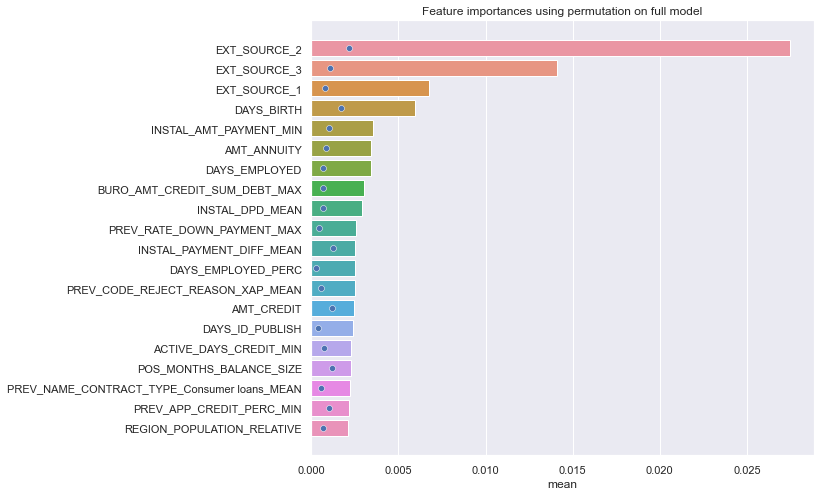

In [404]:
plt.figure(figsize=(9, 8))
sns.barplot(x='mean', y=feature_importance_df.index[:20], data=feature_importance_df[:20])
sns.scatterplot(x='std', y=feature_importance_df.index[:20], data=feature_importance_df[:20], legend='auto')
plt.title("Feature importances using permutation on full model")
plt.show()

In [405]:
#Regardons le score de prédiction ce modèle
train_probs = forest.predict_proba(X_train)[:,1] 
y_test_proba = forest.predict_proba(X_test)[:,1]

y_pred = forest.predict(X_test)

print(f'Train ROC AUC Score: {roc_auc_score(y_train, train_probs)}')
print(f'Test ROC AUC  Score: {roc_auc_score(y_test, y_test_proba)}')

accuracy_score(y_test, y_pred)
print(f"The f1-sore of the model is {np.round(f1_score(y_test,y_pred), 2)*100} %")

Train ROC AUC Score: 1.0
Test ROC AUC  Score: 0.7496131165207475
The f1-sore of the model is 68.0 %


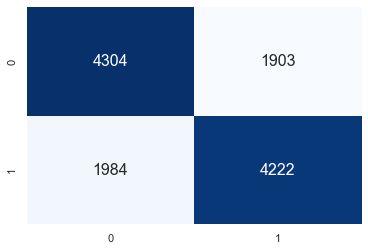

In [408]:
#Matrice de confusion
conf_mat = confusion_matrix(y_test, y_pred)
conf_mat = pd.DataFrame(conf_mat, range(2), range(2))
sns.heatmap(conf_mat, annot=True, annot_kws={"size": 16}, fmt='g', cmap='Blues', cbar=False)
plt.show()

##### Feature les moins importants

In [409]:
#min
feature_importance_df['mean'].min()

-0.0014662047853057024

In [410]:
#max
feature_importance_df['mean'].max()

0.027455087408362222

In [411]:
#Les variables les plus important selon le modèle
important_features = feature_importance_df[feature_importance_df['mean'] > 0].index.to_list()
len(important_features)

182

In [412]:
#Sauvegarde des données avec les features sélectionnées
important_features.insert(0,'TARGET')
data_preproced[important_features].to_csv(Path(PROJECT_ROOT + '/data/data_preprocessed_final.csv'))

In [413]:
datas_final = data_preproced[important_features]
datas_final.head()

,TARGET,EXT_SOURCE_2,EXT_SOURCE_3,EXT_SOURCE_1,DAYS_BIRTH,INSTAL_AMT_PAYMENT_MIN,AMT_ANNUITY,DAYS_EMPLOYED,BURO_AMT_CREDIT_SUM_DEBT_MAX,INSTAL_DPD_MEAN,...,BURO_CNT_CREDIT_PROLONG_SUM,LIVINGAPARTMENTS_AVG,BURO_CREDIT_DAY_OVERDUE_MEAN,CC_CNT_DRAWINGS_POS_CURRENT_MIN,PREV_NAME_CONTRACT_STATUS_Refused_MEAN,AMT_REQ_CREDIT_BUREAU_QRT,BURO_STATUS_X_MEAN_MEAN,PREV_NAME_CASH_LOAN_PURPOSE_Building a house or an annex_MEAN,CC_CNT_DRAWINGS_OTHER_CURRENT_MEAN,BURO_CREDIT_CURRENCY_currency 1_MEAN
0,1.0,0.2630,0.1394,0.0830,-9461,9251.775,24700.5,-637.0,245781.0,0.0000,...,0.0,0.0202,0.0,NaN,0.0000,0.0,0.162,0.0,NaN,1.0
1,0.0,0.6220,NaN,0.3113,-16765,6662.970,35698.5,-1188.0,0.0,0.0000,...,0.0,0.0773,0.0,NaN,0.0000,0.0,NaN,0.0,NaN,1.0
2,0.0,0.5560,0.7295,NaN,-19046,5357.250,6750.0,-225.0,0.0,0.0000,...,0.0,NaN,0.0,NaN,0.0000,0.0,NaN,0.0,NaN,1.0
3,0.0,0.6504,NaN,NaN,-19005,2482.920,29686.5,-3040.0,NaN,0.0000,...,NaN,NaN,NaN,NaN,0.1111,NaN,NaN,0.0,NaN,NaN
4,0.0,0.3228,NaN,NaN,-19932,0.180,21865.5,-3038.0,0.0,0.9546,...,0.0,NaN,0.0,NaN,0.0000,0.0,NaN,0.0,NaN,1.0


In [414]:
datas_final.shape

(356251, 183)

#Impute EXT_SOURCEs
#Kaggle kernel
def feat_ext_source(df):
    
    #Ajout de d'autre variable numérique
    x1 = df['EXT_SOURCE_1'].fillna(-1) + 1e-1
    x2 = df['EXT_SOURCE_2'].fillna(-1) + 1e-1
    x3 = df['EXT_SOURCE_3'].fillna(-1) + 1e-1
    
    df['EXT_SOURCE_1over2_NAminus1_Add0.1'] = x1/x2
    df['EXT_SOURCE_2over1_NAminus1_Add0.1'] = x2/x1
    df['EXT_SOURCE_1over3_NAminus1_Add0.1'] = x1/x3
    df['EXT_SOURCE_3over1_NAminus1_Add0.1'] = x3/x1
    df['EXT_SOURCE_2over3_NAminus1_Add0.1'] = x2/x3
    df['EXT_SOURCE_3over2_NAminus1_Add0.1'] = x3/x2
    
    df['EXT_SOURCE_na1_2'] = (df['EXT_SOURCE_1'].isnull()) * (df['EXT_SOURCE_2'].fillna(0))
    df['EXT_SOURCE_na1_3'] = (df['EXT_SOURCE_1'].isnull()) * (df['EXT_SOURCE_3'].fillna(0))
    df['EXT_SOURCE_na2_1'] = (df['EXT_SOURCE_2'].isnull()) * (df['EXT_SOURCE_1'].fillna(0))
    df['EXT_SOURCE_na2_3'] = (df['EXT_SOURCE_2'].isnull()) * (df['EXT_SOURCE_3'].fillna(0))
    df['EXT_SOURCE_na3_1'] = (df['EXT_SOURCE_3'].isnull()) * (df['EXT_SOURCE_1'].fillna(0))
    df['EXT_SOURCE_na3_2'] = (df['EXT_SOURCE_3'].isnull()) * (df['EXT_SOURCE_2'].fillna(0))
    
    #Imputation
    df[['EXT_SOURCE_1',
        'EXT_SOURCE_2',
        'EXT_SOURCE_3']] = df[['EXT_SOURCE_1',
                               'EXT_SOURCE_2',
                               'EXT_SOURCE_3']].fillna(0)
    #df['CREDIT_LENGTH'] = df['AMT_CREDIT'] / df['AMT_ANNUITY']
    
    return df

## Gestion du déséquibre de class



In [86]:
important_features.insert(0,'TARGET')

In [87]:
important_features

['TARGET',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'EXT_SOURCE_1',
 'DAYS_BIRTH',
 'DAYS_LAST_PHONE_CHANGE',
 'CC_AMT_CREDIT_LIMIT_ACTUAL_SUM',
 'FLOORSMAX_AVG',
 'POS_SK_DPD_MAX',
 'NAME_EDUCATION_TYPE_Secondary / secondary special',
 'CNT_CHILDREN',
 'INCOME_CREDIT_PERC',
 'NAME_EDUCATION_TYPE_Higher education',
 'BURO_DAYS_CREDIT_VAR',
 'INSTAL_DBD_MEAN',
 'PREV_WEEKDAY_APPR_PROCESS_START_SUNDAY_MEAN',
 'PAYMENT_RATE',
 'INSTAL_AMT_INSTALMENT_SUM',
 'DAYS_ID_PUBLISH',
 'INSTAL_AMT_PAYMENT_MIN',
 'BURO_STATUS_1_MEAN_MEAN',
 'PREV_DAYS_DECISION_MEAN',
 'NAME_INCOME_TYPE_Pensioner',
 'REGION_RATING_CLIENT',
 'PREV_APP_CREDIT_PERC_VAR',
 'CC_CNT_DRAWINGS_ATM_CURRENT_VAR',
 'BURO_DAYS_CREDIT_MAX',
 'PREV_AMT_APPLICATION_MIN',
 'AMT_CREDIT',
 'NAME_FAMILY_STATUS_Civil marriage',
 'NAME_CONTRACT_TYPE_Revolving loans',
 'ACTIVE_AMT_CREDIT_MAX_OVERDUE_MEAN',
 'PREV_NAME_CLIENT_TYPE_New_MEAN',
 'INSTAL_NUM_INSTALMENT_VERSION_NUNIQUE',
 'NAME_CONTRACT_TYPE_Cash loans',
 'OBS_30_CNT_SOCIAL_CIRCLE',


### Première étape 

In [395]:
import imblearn
from imblearn import FunctionSampler
from imblearn.over_sampling import ADASYN, SMOTE, RandomOverSampler
from imblearn.pipeline import make_pipeline, Pipeline
from sklearn.neighbors import KNeighborsClassifier

print(imblearn.__version__)

0.9.1


In [191]:
#Reduction des données pour tester les méthodes d'équilibrage
nb_class_1 = int(len(datas_final[datas_final.TARGET == 1])*70/100)
nb_class_0 = int(len(datas_final[datas_final.TARGET == 0])*70/100)
print(f"70% des la classe 0 : {nb_class_0}\n70% de la classe 1 : {nb_class_1}")

70% des la classe 0 : 197877
70% de la classe 1 : 17377


In [192]:
df = pd.concat([
        datas_final[datas_final.TARGET == 0].sample(nb_class_0), 
        datas_final[datas_final.TARGET == 1].sample(nb_class_1)
    ], ignore_index=True
)

In [193]:
df.TARGET.value_counts()

0.0    197877
1.0     17377
Name: TARGET, dtype: int64

In [194]:
# Separation des données
train_df = df[df['TARGET'].notnull()]
test_df = df[df['TARGET'].isnull()]
print("Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))

Train shape: (215254, 128), test shape: (0, 128)


In [195]:
#imputation
train_df.fillna(0, inplace=True)
test_df.fillna(0, inplace=True)
train_df.isna().sum().sum()

/Users/kone/opt/anaconda3/envs/oc_project_env/lib/python3.8/site-packages/pandas/core/frame.py:5176: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


0

In [196]:
train_df = remove_infite(train_df)
test_df = remove_infite(test_df)

In [197]:
y = train_df['TARGET']
del train_df['TARGET']
del test_df['TARGET']

Le lebal positive minoritaire est la class : 1.0


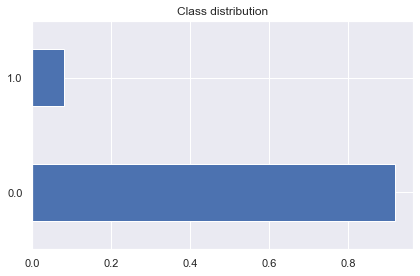

In [198]:
class_distribution = pd.Series(y).value_counts(normalize=True)
ax = class_distribution.plot.barh()
ax.set_title("Class distribution")
pos_label = class_distribution.idxmin()
plt.tight_layout()
print(f"Le lebal positive minoritaire est la class : {pos_label}")

In [206]:
classifier = KNeighborsClassifier(n_neighbors=5)

pipeline = [
    make_pipeline(FunctionSampler(), classifier),
    make_pipeline(RandomOverSampler(random_state=42), classifier),
    make_pipeline(ADASYN(random_state=42), classifier),
    make_pipeline(SMOTE(random_state=42), classifier),
]

In [207]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1001)

In [201]:
X = train_df.values
y = y.values

In [208]:
disp = []
for model in tqdm(pipeline):
    # compute the mean fpr/tpr to get the mean ROC curve
    mean_tpr, mean_fpr = 0.0, np.linspace(0, 1, 100)
    for train, test in cv.split(X, y):
        
        model.fit(X[train], y[train])
        y_proba = model.predict_proba(X[test])

        pos_label_idx = np.flatnonzero(model.classes_ == pos_label)[0]
        fpr, tpr, thresholds = roc_curve(
            y[test], y_proba[:, pos_label_idx], pos_label=pos_label
        )
        mean_tpr += np.interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0

    mean_tpr /= cv.get_n_splits(X, y)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)

    # Create a display that we will reuse to make the aggregated plots for
    # all methods
    disp.append(
        RocCurveDisplay(
            fpr=mean_fpr,
            tpr=mean_tpr,
            roc_auc=mean_auc,
            estimator_name=f"{model[0].__class__.__name__}",
        )
    )

100%|████████████████████████████████████████████████████████████████████████████████████████| 4/4 [20:27<00:00, 306.89s/it]


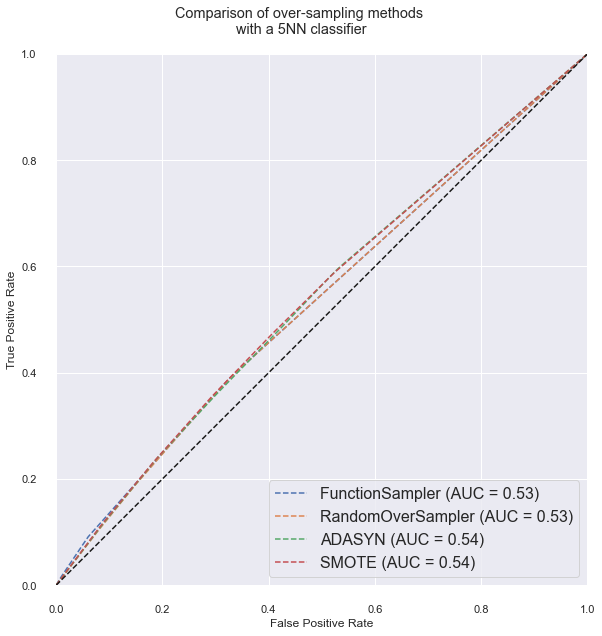

In [209]:
fig, ax = plt.subplots(figsize=(9, 9))
for d in disp:
    d.plot(ax=ax, linestyle="--")
ax.plot([0, 1], [0, 1], linestyle="--", color="k")
ax.axis("square")
fig.suptitle("Comparison of over-sampling methods \nwith a 5NN classifier")
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
sns.despine(offset=10, ax=ax)
plt.legend(loc="lower right", fontsize=16)
plt.tight_layout()
plt.show()


### Validation-Croisée

In [228]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from imblearn.under_sampling import RandomUnderSampler

In [231]:
data_preproced.head()

,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,REGION_POPULATION_RELATIVE,DAYS_BIRTH,...,CC_NAME_CONTRACT_STATUS_Approved_MIN,CC_NAME_CONTRACT_STATUS_Completed_SUM,CC_NAME_CONTRACT_STATUS_Refused_MIN,CC_NAME_CONTRACT_STATUS_Sent proposal_MIN,CC_NAME_CONTRACT_STATUS_Sent proposal_MAX,CC_NAME_CONTRACT_STATUS_nan_MIN,CC_NAME_CONTRACT_STATUS_nan_MAX,CC_NAME_CONTRACT_STATUS_nan_MEAN,CC_NAME_CONTRACT_STATUS_nan_SUM,CC_NAME_CONTRACT_STATUS_nan_VAR
0,1.0,0,0,0,0,202500.0,406597.5,24700.5,0.018800,-9461,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.0,1,0,1,0,270000.0,1293502.5,35698.5,0.003542,-16765,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.0,0,1,0,0,67500.0,135000.0,6750.0,0.010030,-19046,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.0,1,0,0,0,135000.0,312682.5,29686.5,0.008020,-19005,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0,0,0,0,121500.0,513000.0,21865.5,0.028660,-19932,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [1]:
#Reduction des données pour tester les méthodes d'équilibrage
nb_class_1 = int(len(datas_final[datas_final.TARGET == 1])*10/100)
nb_class_0 = int(len(datas_final[datas_final.TARGET == 0])*10/100)
print(f"10% des la classe 0 : {nb_class_0}\n10% de la classe 1 : {nb_class_1}")

df = pd.concat([
         datas_final[datas_final.TARGET == 0].sample(nb_class_0), 
         datas_final[datas_final.TARGET == 1].sample(nb_class_1)
    ], ignore_index=True
)

# Separation des données
train_df = df[df['TARGET'].notnull()]
test_df = df[df['TARGET'].isnull()]
print("Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))

#imputation
train_df.fillna(0, inplace=True)
test_df.fillna(0, inplace=True)
train_df.isna().sum().sum()

train_df = remove_infite(train_df)
test_df = remove_infite(test_df)

y = train_df['TARGET']
del train_df['TARGET']
del test_df['TARGET']

X = train_df.values
y = y.values

NameError: name 'datas_final' is not defined

In [302]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

In [243]:
#Accuracy ROC AUC sans re-équilibrage
classifier = KNeighborsClassifier(n_neighbors=5)
scores = cross_val_score(classifier, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
print('Mean ROC AUC: %.3f' % mean(scores))

Mean ROC AUC: 0.533


In [114]:
X[train]

KeyError: "None of [Int64Index([ 30727,  30728,  30729,  30731,  30732,  30734,  30735,  30736,\n             30737,  30739,\n            ...\n            307496, 307497, 307498, 307499, 307500, 307501, 307502, 307503,\n            307504, 307505],\n           dtype='int64', length=276755)] are in the [columns]"

In [119]:
for train, test in cv.split(X, y):
    
    train

In [121]:
X

array([[0.263  , 0.1394 , 0.083  , ..., 0.     , 0.     , 1.     ],
       [0.622  , 0.     , 0.3113 , ..., 0.     , 0.     , 0.     ],
       [0.556  , 0.7295 , 0.     , ..., 0.     , 0.     , 1.     ],
       ...,
       [0.5356 , 0.2189 , 0.744  , ..., 0.     , 1.     , 0.     ],
       [0.514  , 0.661  , 0.     , ..., 0.     , 1.     , 0.     ],
       [0.7085 , 0.11395, 0.7344 , ..., 0.     , 1.     , 0.     ]])

In [ ]:
fig, ax = plt.subplots(figsize=(9, 9))
for d in disp:
    d.plot(ax=ax, linestyle="--")
ax.plot([0, 1], [0, 1], linestyle="--", color="k")
ax.axis("square")
fig.suptitle("Comparison of over-sampling methods \nwith a RandomForestClassifier classifier")
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
sns.despine(offset=10, ax=ax)
plt.legend(loc="lower right", fontsize=16)
plt.tight_layout()
plt.show()


In [244]:
steps = [('over', SMOTE()), ('model', KNeighborsClassifier(n_neighbors=5))]
pipeline = Pipeline(steps=steps)

In [245]:
scores = cross_val_score(pipeline, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
print('Mean ROC AUC: %.3f' % mean(scores))

Mean ROC AUC: 0.543


In [312]:
k_values = range(1, 21)
Scores = []
for k in tqdm(k_values):
    # define pipeline
    model = KNeighborsClassifier(n_neighbors=5)
    over = SMOTE(k_neighbors=k, random_state=1)
    
    steps = [('over', over), ('model', model)]
    pipeline = Pipeline(steps=steps)
    # evaluate pipeline
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(pipeline, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
    score = mean(scores)
    Scores.append(score)
    print('> k=%d, Mean ROC AUC: %.3f' % (k, score))

  5%|████▍                                                                                   | 1/20 [00:44<14:12, 44.84s/it]

> k=1, Mean ROC AUC: 0.546


 10%|████████▊                                                                               | 2/20 [01:16<11:09, 37.21s/it]

> k=2, Mean ROC AUC: 0.549


 15%|█████████████▏                                                                          | 3/20 [01:48<09:52, 34.83s/it]

> k=3, Mean ROC AUC: 0.552


 20%|█████████████████▌                                                                      | 4/20 [02:20<08:59, 33.74s/it]

> k=4, Mean ROC AUC: 0.551


 25%|██████████████████████                                                                  | 5/20 [02:56<08:36, 34.40s/it]

> k=5, Mean ROC AUC: 0.552


 30%|██████████████████████████▍                                                             | 6/20 [03:29<07:56, 34.06s/it]

> k=6, Mean ROC AUC: 0.552


 35%|██████████████████████████████▊                                                         | 7/20 [04:01<07:14, 33.40s/it]

> k=7, Mean ROC AUC: 0.555


 40%|███████████████████████████████████▏                                                    | 8/20 [04:34<06:39, 33.31s/it]

> k=8, Mean ROC AUC: 0.555


 45%|███████████████████████████████████████▌                                                | 9/20 [05:08<06:07, 33.44s/it]

> k=9, Mean ROC AUC: 0.555


 50%|███████████████████████████████████████████▌                                           | 10/20 [05:39<05:27, 32.78s/it]

> k=10, Mean ROC AUC: 0.555


 55%|███████████████████████████████████████████████▊                                       | 11/20 [06:16<05:05, 33.99s/it]

> k=11, Mean ROC AUC: 0.558


 60%|████████████████████████████████████████████████████▏                                  | 12/20 [06:56<04:45, 35.67s/it]

> k=12, Mean ROC AUC: 0.559


 65%|████████████████████████████████████████████████████████▌                              | 13/20 [07:37<04:21, 37.29s/it]

> k=13, Mean ROC AUC: 0.562


 70%|████████████████████████████████████████████████████████████▉                          | 14/20 [08:16<03:47, 37.98s/it]

> k=14, Mean ROC AUC: 0.558


 75%|█████████████████████████████████████████████████████████████████▎                     | 15/20 [08:51<03:04, 36.98s/it]

> k=15, Mean ROC AUC: 0.560


 80%|█████████████████████████████████████████████████████████████████████▌                 | 16/20 [09:34<02:35, 38.77s/it]

> k=16, Mean ROC AUC: 0.559


 85%|█████████████████████████████████████████████████████████████████████████▉             | 17/20 [10:12<01:55, 38.59s/it]

> k=17, Mean ROC AUC: 0.560


 90%|██████████████████████████████████████████████████████████████████████████████▎        | 18/20 [10:48<01:15, 37.80s/it]

> k=18, Mean ROC AUC: 0.562


 95%|██████████████████████████████████████████████████████████████████████████████████▋    | 19/20 [11:30<00:39, 39.19s/it]

> k=19, Mean ROC AUC: 0.561


100%|███████████████████████████████████████████████████████████████████████████████████████| 20/20 [12:18<00:00, 36.90s/it]

> k=20, Mean ROC AUC: 0.560


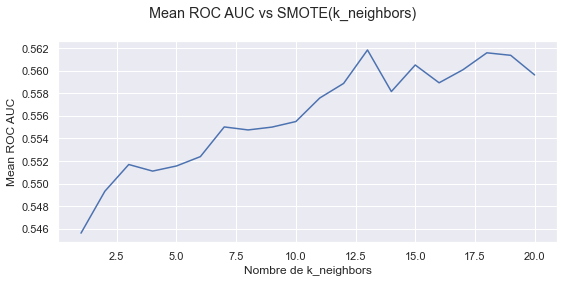

In [313]:
fig, ax = plt.subplots(figsize=(8, 4))

plt.plot(k_values, Scores) #.plot(ax=ax, linestyle="--")
ax.set_xlabel("Nombre de k_neighbors")
ax.set_ylabel("Mean ROC AUC")
fig.suptitle("Mean ROC AUC vs SMOTE(k_neighbors)")
plt.tight_layout()
plt.show()

In [314]:
steps = [('SMOTE', SMOTE(k_neighbors=13))]
pipeline = Pipeline(steps=steps)
X_rs, y_rs = pipeline.fit_resample(X, y)

In [315]:
X.shape

(30750, 127)

In [316]:
df_rs = pd.DataFrame(X_rs, columns=train_df.columns)
df_rs['TARGET'] = y_rs
df_rs.head()

,EXT_SOURCE_2,EXT_SOURCE_3,EXT_SOURCE_1,DAYS_BIRTH,DAYS_LAST_PHONE_CHANGE,CC_AMT_CREDIT_LIMIT_ACTUAL_SUM,FLOORSMAX_AVG,POS_SK_DPD_MAX,NAME_EDUCATION_TYPE_Secondary / secondary special,CNT_CHILDREN,...,CC_CNT_INSTALMENT_MATURE_CUM_MIN,ORGANIZATION_TYPE_Transport: type 3,PREV_NAME_YIELD_GROUP_middle_MEAN,PREV_NAME_CASH_LOAN_PURPOSE_Building a house or an annex_MEAN,FLAG_DOCUMENT_13,BURO_STATUS_4_MEAN_MEAN,BURO_CREDIT_DAY_OVERDUE_MEAN,REG_CITY_NOT_WORK_CITY,NAME_FAMILY_STATUS_Single / not married,TARGET
0,0.6640,0.7236,0.0000,-22662.0,-2812.0,0.0,0.3333,2272.0,1.0,0.0,...,0.0,0.0,0.3333,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.4517,0.8193,0.0000,-18658.0,-225.0,0.0,0.1667,0.0,1.0,0.0,...,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.3657,0.7610,0.0000,-10441.0,-337.0,0.0,0.0000,0.0,1.0,0.0,...,0.0,0.0,0.2500,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.6660,0.6094,0.5503,-14854.0,-612.0,0.0,0.1667,0.0,0.0,0.0,...,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.2920,0.0000,0.0000,-21827.0,-1625.0,0.0,0.0000,29.0,0.0,0.0,...,0.0,0.0,0.2856,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [248]:
over = SMOTE(sampling_strategy=0.1, random_state=42)
under = RandomUnderSampler(sampling_strategy=0.5, random_state=42)
steps = [('over', over), ('under', under), ('model', KNeighborsClassifier(n_neighbors=5))]
pipeline = Pipeline(steps=steps)

In [249]:
scores = cross_val_score(pipeline, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
print('Mean ROC AUC: %.3f' % mean(scores))

Mean ROC AUC: 0.550


In [317]:
df_rs.shape

(56536, 128)

In [318]:
df_rs.TARGET.value_counts()

0.0    28268
1.0    28268
Name: TARGET, dtype: int64

In [394]:
#Variable à normalisées
len(var_to_norm)

153

In [ ]:
#Test nor

In [ ]:
sk

range(1, 21)